## <u> Introduction </u>

Word embedding is a vector representation of a particular word. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

The most straightforward method for word embedding is using one-hot encoding to map each word to a one-hot vector. Although one-hot encoding is very simple, it's downside is that it is not easy to measure relationships between words in a mathematical way.

<b>Word2Vec</b> is a predictive model for learning word embeddings from raw text. It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.

Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

[Deeplearning4j](https://deeplearning4j.org/) implements a distributed form of Word2vec for Java and Scala, which works on Spark with GPUs. Word2vec’s applications extend beyond parsing sentences. It can be applied just as well to genes, code, likes, playlists, social media graphs and other verbal or symbolic series in which patterns may be discerned because words are discrete states like the other data mentioned above, and we are looking for the transitional probabilities between those states: the likelihood that they will co-occur. So gene2vec, like2vec and follower2vec are all possible.

Given enough data, usage and contexts, Word2vec can make highly accurate guesses about a word’s meaning based on past appearances. Those guesses can be used to establish a word’s association with other words (e.g. “man” is to “boy” what “woman” is to “girl”), or cluster documents and classify them by topic. Those clusters can form the basis of search, [sentiment analysis](https://github.com/eclipse/deeplearning4j-examples/blob/master/dl4j-examples/src/main/java/org/deeplearning4j/examples/recurrent/word2vecsentiment/Word2VecSentimentRNN.java) and recommendations in such diverse fields as scientific research, legal discovery, e-commerce and customer relationship management.


It comes in two flavors:

### <u> CBOW - Continuous Bag-of-Words model </u>
- Predicts target words from source context words.
- CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets.

### <u> Skip-Gram model </u>
- Predicts source context-words from the target words.
- Skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets.

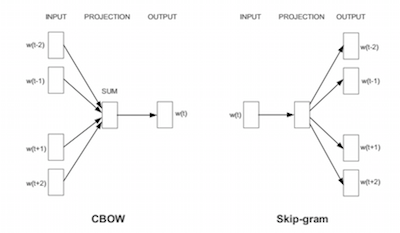

This tutorial covers the skip gram neural network architecture for Word2Vec.

### <u> How does Word2Vec produce word embeddings ? </u>
Word2Vec is a simple neural network with a single hidden layer, and like all neural networks it has weights and during training its goal is to adjust those weights to reduce a loss function. We will take these hidden layer weights and use them as our word embeddings.

<i>Another place we have seen this trick is where an auto-encoder is trained to compress an input vector in the hidden layer and decompress it back to the original in the output layer. After training the model, the output layer (the decompression step) is tossed out and only the hidden layer is used as it has learned good features.</i>

### <u> Architecture </u>
The architecture is similar to an autoencoder’s one, we take a large input vector, compress it down to a smaller dense vector and then instead of decompressing it back to the original input vector as we do with autoencoders, we output probabilities of target words.

We feed words as one-hot vectors, which is basically a vector of the same length as the vocabulary, filled with "0"s except at the index that represents the word we want to represent, which is assigned “1”.

The hidden layer is a standard fully-connected (Dense) layer whose weights are the word embeddings.

The output layer outputs probabilities for the target words from the vocabulary.

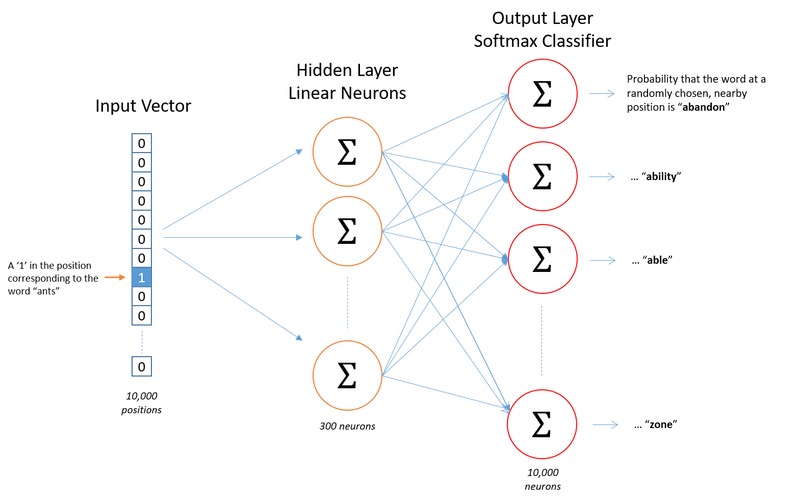

There is no activation function on the hidden layer neurons, but the output neurons use softmax.

When training this network on word pairs, the input is a one-hot vector representing the input word (ants) and the training output is also a one-hot vector representing the output word. But when we evaluate the trained network on an input word, the output vector will actually be a probability distribution (i.e., a bunch of floating point values, not a one-hot vector).

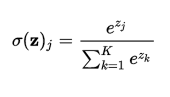

For our example, we’re learning word vectors with 300 features so the hidden layer is going to be represented by a weight matrix with 10,000 rows (one for every word in our vocabulary) and 300 columns (one for every hidden neuron).

The end goal of all of this is to learn hidden layer weight matrix and then toss out the output layer when we’re done!


<i>Let's say in our training corpus, every single occurrence of the word 'York' is preceded by the word 'New'. That is, at least according to the training data, there is a 100% probability that 'New' will be in the vicinity of 'York'. However, if we take the 10 words in the vicinity of 'York' and randomly pick one of them, the probability of it being 'New' is not 100%; we may have picked one of the other words in the vicinity.</i>

### <u>Insight</u>

- If we take any two vectors, both of say, 300 dimensions, that are randomly initialized with some values, and if we add just a tiny bit of one vector to the other, the vectors get “closer” to each other (the cosine similarity increases), simply by virtue of vector addition. Figure below shows this for 2 dimensions.

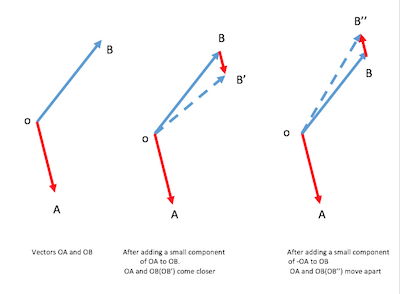

- If we subtract a tiny bit of one vector from the other - the vectors will move “apart” (cosine similarity decreases) by a tiny bit (In the boundary case of both vectors being exact opposite direction of each other, one vector will be nudged to eventually flip from opposite to same direction, as its magnitude decreases/increases with each positive nudge).

- During Word2Vec training , in each step, every word is either (1) nudged/pulled closer to words that it co-occurs with, within a specified window or (2) nudged/pushed away from all the other words that it does not appear with. Since typical neighborhood window is small (e.g. 5–15) pulling operations when a word is tugged by its neighbors is bounded by this window size; however for a large corpus, pushing away non-neighborhood words is an expensive operation to do. So word2vec has two schemes (hierarchical and negative sampling), where nudging away of all other words not in neighborhood of a word is avoided.

- In the negative sampling method, every time a word is brought closer to its neighbors, a small number of other words (randomly chosen from a unigram distribution of all words in the corpus) are nudged/pushed away.

- In the hierarchical sampling method, every neighboring word is pulled closer or further apart from a subset of words (log2(corpus size)), where the word subset for each word is chosen from a tree structure (binary Huffman tree is used in word2vec where short binary codes are assigned to frequent words).

- Word2vec training only brings together words that are in the same line of a word and within the specified window context. In essence, words that do not co-occur, are never explicitly nudged closer together ( but may be pushed apart in negative sampling case).

The net effect after the training of word vectors pulling/pushing each other closer/apart is:

- Entities that appear together get pulled closer to each other.
- Entities that do not even appear together in sentences, but are transitively linked by neighbor entities, by their occurrences in training corpus, get pulled closer.
- Glue words (or stop words) like “the”, “are”,”in” pull each other closer and away from the entities they occur with. Consider a corpus of 6.4 billion words with 20 million unique words, the top neighbors of the word “the” are: “of”, ”in”, ”and”, ”which”, ”a”.

The training on words has an impact on the magnitude on word vectors:

- The vector magnitude of words that occur the most or the least in the corpus have lower magnitudes than those in the middle. For instance, in a 20 million unique word corpus, a word like “the” that occurs ~780,000 times has a vector magnitude of 2.39. A word that occurs just once in the corpus has a magnitude of .606; a word that occurs 64,00 times has a magnitude of 4.7. Words in the middle of the occurrence frequency scale, 2000–70,000 occurrences, range in magnitude from 4 to 12.

- This may be just a consequence of the fact that a frequently occurring word like “the” gets pulled closer in all directions, leading to the overall reduction in its magnitude - since its context spans nearly the whole corpus, for every neighbor word that nudges it in a certain direction, there is likely to be another neighbor word vector that nudges it closer to itself, in the exact opposite direction cancelling the effect of the previous nudge. However, despite this, “the” along with its high frequency cohorts like “in”, manage to huddle together, given their large numbers (“in” would pull “the” many more times than any entity like “dogs”,”cats” etc. in a large corpus). For words that occur very rarely, the nudges are few relative to the other words anyway (e.g. for 5 full iterations over the corpus, the vector for the word “the” will be pulled, or updated in 780,000*5 iterations, whereas the vector for a word that occurs just once in corpus will be updated a meagre 5 iterations) - hence their magnitudes are also low. (The hyperparameter for subsampling is assumed to be zero in the discussion above).

- The vector magnitudes are a relevance measure for the “important words” in a corpus. High frequency and low frequency words have low magnitudes, while those in the middle have high magnitudes. For instance, in a 11 billion word, 66 million unique word corpus, just 2% of terms have magnitudes above 4 - all high frequency stop words and low frequency words have magnitudes less than 4. While low frequency words may show up like “needle in a haystack” in the neighborhood of some terms , and may prove insightful in some applications (unlike their high frequency word counterparts who seem to have no utility at all in most cases - they can even be burdensome; for instance when trying to generate phrases - they blow up phrase combinations when using word2phrase to generate phrases ; section 4 in Mikholov’s paper ), they are often not reliable since they are nudged so few times, as mentioned above (though according to Mikholov’s paper subsampling improves vector representations of low frequency words).

### <u> Semantic and syntactic relationships </u>

If different words are similar in context, Word2Vec should have similar outputs when these words are passed as inputs, in order to have similar outputs, the computed word vectors (in the hidden layer) for these words need to be similar, thus Word2Vec is motivated to learn similar word vectors for words in similar context.

Word2Vec is able to capture multiple different degrees of similarity between words, such that semantic and syntactic patterns can be reproduced using vector arithmetic. Patterns such as “Man:Woman::Brother:Sister” can be generated through algebraic operations on the vector representations of these words such that the vector representation of “Brother” - ”Man” + ”Woman” produces a result which is closest to the vector representation of “Sister” in the model. Such relationships can be generated for a range of semantic relations (such as Country—Capital) as well as syntactic relations (e.g. present tense—past tense).

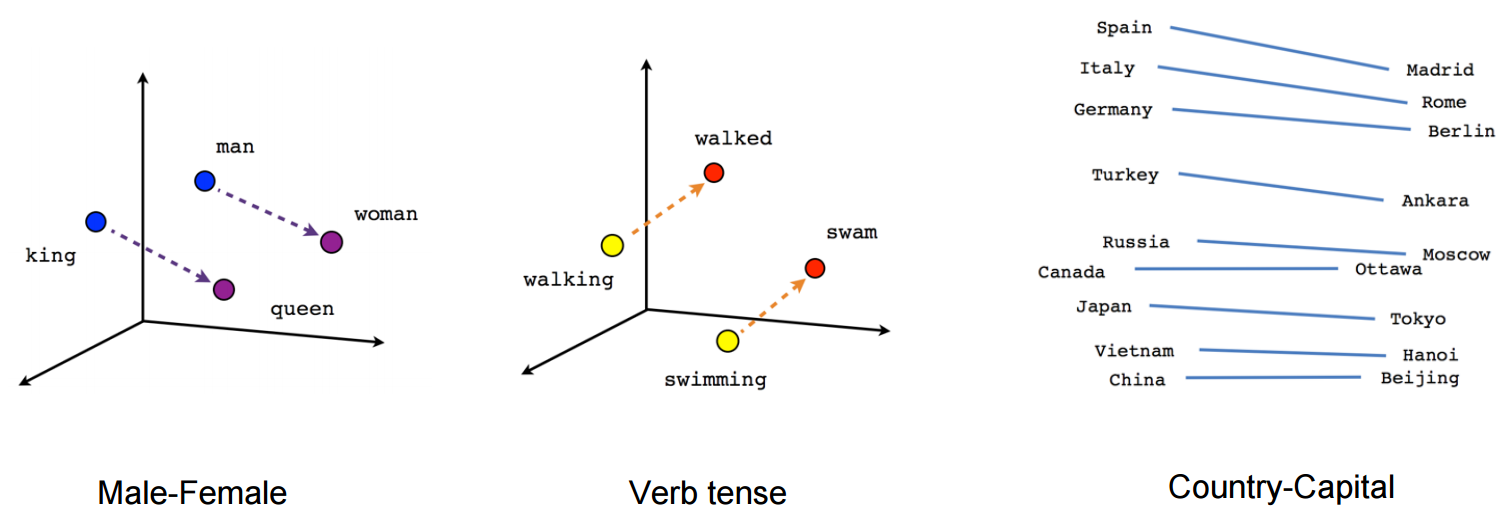

### <u> Training algorithm </u>
We’ll train the neural network by feeding it word pairs found in our training documents. The below example shows some of the training samples (word pairs) we would take from the sentence “The quick brown fox jumps over the lazy dog.” We’ve used a small window size of 2 just for the example. The word highlighted in blue is the input word.

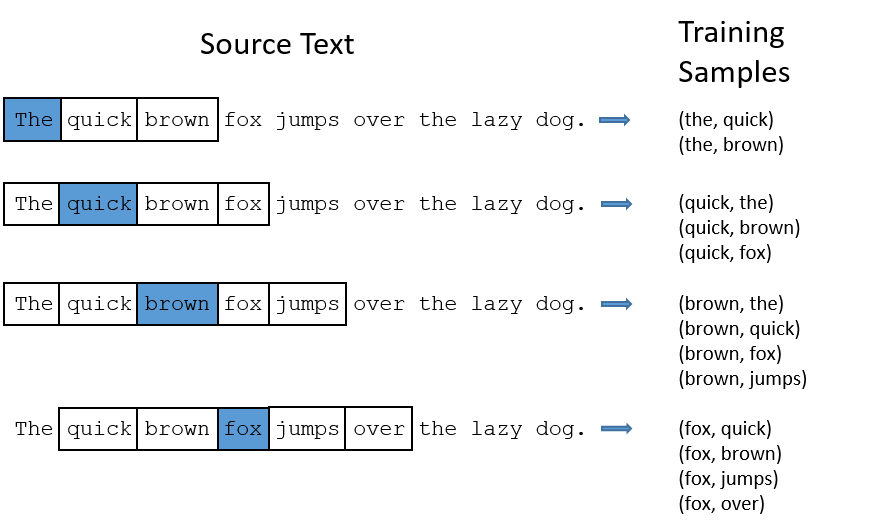

The network is going to learn the statistics from the number of times each pairing shows up. For example, the network is probably going to get many more training samples of (“brown”, “fox”) than it is of (“brown”, “over”). When the training is finished, if we give it the word “brown” as input, then it will output a much higher probability for “fox” than it will for “over”.

A Word2vec model can be trained with hierarchical softmax and/or negative sampling, usually, just negative sampling is used.

In the example, we had word vectors with 300 components, and a vocabulary of 10,000 words. Recall that the neural network had two weight matrices–a hidden layer and output layer. Both of these layers would have a weight matrix with 300 x 10,000 = 3 million weights each. Running gradient descent on a neural network that large is going to be slow.

The authors of Word2Vec addressed these issues in their second paper with the following two innovations:

- Subsampling frequent words to decrease the number of training examples.
- Modifying the optimization objective with a technique they called “Negative Sampling”, which causes each training sample to update only a small percentage of the model’s weights.

Subsampling frequent words and applying Negative Sampling not only reduced the compute burden of the training process, but also improved the quality of their resulting word vectors as well.

### <u>Subsampling Frequent Words</u>

Wrt. above example, there are two “problems” with common words like “the”:

- When looking at word pairs, (“fox”, “the”) doesn’t tell us much about the meaning of “fox”. “the” appears in the context of pretty much every word.
- We will have many more samples of (“the”, …) than we need to learn a good vector for “the”.

Word2Vec implements a “subsampling” scheme to address this. For each word we encounter in our training text, there is a chance that we will effectively delete it from the text. The probability that we cut the word is related to the word’s frequency.

If we have a window size of 10, and we remove a specific instance of “the” from our text:

- As we train on the remaining words, “the” will not appear in any of their context windows.
- We’ll have 10 fewer training samples where “the” is the input word.


### <u> Negative Sampling </u>

Training a neural network means taking a training example and adjusting all of the neuron weights slightly so that it predicts that training sample more accurately. In other words, each training sample will tweak all of the weights in the neural network.

As we discussed above, the size of our word vocabulary means that our skip-gram neural network has a tremendous number of weights, all of which would be updated slightly by every one of our billions of training samples!

Negative sampling addresses this by having each training sample only modify a small percentage of the weights, rather than all of them. Here’s how it works.

When training the network on the word pair (“fox”, “quick”), recall that the “label” or “correct output” of the network is a one-hot vector. That is, for the output neuron corresponding to “quick” to output a 1, and for all of the other thousands of output neurons to output a 0.

With negative sampling, we are instead going to randomly select just a small number of “negative” words (let’s say 5) to update the weights for. (In this context, a “negative” word is one for which we want the network to output a 0 for). We will also still update the weights for our “positive” word (which is the word “quick” in our current example).

<i>The paper says that selecting 5-20 words works well for smaller datasets, and you can get away with only 2-5 words for large datasets.</i>

Recall that the output layer of our model has a weight matrix that’s 300 x 10,000. So we will just be updating the weights for our positive word (“quick”), plus the weights for 5 other words that we want to output 0. That’s a total of 6 output neurons, and 1,800 weight values total. That’s only 0.06% of the 3M weights in the output layer!

In the hidden layer, only the weights for the input word are updated (this is true whether you’re using Negative Sampling or not).

#### <u>Selecting Negative Samples</u>
The “negative samples” (that is, the 5 output words that we’ll train to output 0) are selected using a “unigram distribution”, where more frequent words are more likely to be selected as negative samples.

For instance, suppose we had our entire training corpus as a list of words, and we chose our 5 negative samples by picking randomly from the list. In this case, the probability for picking the word “couch” would be equal to the number of times “couch” appears in the corpus, divided the total number of word occus in the corpus. This is expressed by the following equation:

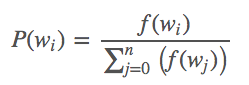

The authors state in their paper that they tried a number of variations on this equation, and the one which performed best was to raise the word counts to the 3/4 power:

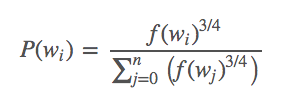

If we play with some sample values, we’ll find that, compared to the simpler equation, this one has the tendency to increase the probability for less frequent words and decrease the probability for more frequent words.

The way this selection is implemented in the C code is interesting. They have a large array with 100M elements (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary multiple times, and the number of times a word’s index appears in the table is given by P(wi) * table_size. Then, to actually select a negative sample, we just generate a random integer between 0 and 100M, and use the word at that index in the table. Since the higher probability words occur more times in the table, we’re more likely to pick those.

### <u> Practical methodology </u>
The use of different model parameters and different corpus sizes can greatly affect the quality of a word2vec model.
Accuracy can be improved in a number of ways, including the choice of model architecture (CBOW or Skip-Gram), increasing the training data set, increasing the number of vector dimensions, and increasing the window size of words considered by the algorithm. Each of these improvements comes with the cost of increased computational complexity and therefore increased model generation time.

In models using large corpora and a high number of dimensions, the skip-gram model yields the highest overall accuracy, and consistently produces the highest accuracy on semantic relationships, as well as yielding the highest syntactic accuracy in most cases. However, the CBOW is less computationally expensive and yields similar accuracy results.

Accuracy increases overall as the number of words used increase, and as the number of dimensions increases. Doubling the amount of training data results in an equivalent increase in computational complexity as doubling the number of vector dimensions.

#### <u> Sub-sampling </u>
Some frequent words often provide little information. Words with frequency above a certain threshold (e.g ‘a’, ‘an’ and ‘that’) may be subsampled to increase training speed and performance. Also, common word pairs or phrases may be treated as single “words” to increase training speed.

#### <u> Dimensionality </u>
Quality of word embedding increases with higher dimensionality. However, after reaching some threshold, the marginal gain will diminish. Typically, the dimensionality of the vectors is set to be between 100 and 1,000.

#### <u> Context window </u>
The size of the context window determines how many words before and after a given word would be included as context words of the given word.

### <u> Q&A </u>

<b>Q: </b><u> Why is cosine similarity better in measuring similarity between vectors than Euclidean in Vector Space model?</u>

<b>A:</b> Cosine distance measures the difference in orientation. Euclidean distance ALSO include difference in magnitude. Cosine similarity is good when we are interested in the direction of our vectors and not in their position in space.

If we compare using cosine, we can find similarities between rare words and common words, as long as the vectors point in roughly the same direction. So we might find that “big” (very common), “enormous” (less common) and “gargantuan” (not common), all come out similar.

If we compare using Euclidean distance, two words will only be similar if their vectors point in roughly the same direction AND they are also roughly the same frequency. This is usually not what we want.

Cosine can also be used for clustering, we can apply it to hierarchical clustering or even K-Means and then we have spherical K-Means. In spherical K-Means the points will be clustered based on their direction.